The following analysis is for the paper 'Penalized prediction' - to show that our method of beta estimation generalized beyond the specific target selected.

In [20]:
import numpy as np
from   sklearn.linear_model import LinearRegression
from   sklearn.metrics import r2_score
from sklearn import linear_model as LM

In [26]:

def regress(response, pred_list, one=False, do_print=True):
    """
    Basic regression function
    :param response:
    :param pred_list:
    :param one:
    :param do_print:
    :return:
    """

    regr = LM.LinearRegression(fit_intercept=one)
    regr.fit(np.asarray(pred_list).swapaxes(0, 1), response)

    presp = regr.predict(np.asarray(pred_list).swapaxes(0, 1))
    r2 = r2_score(response, presp)
    if do_print:
        if one:
            rs = ('%6.4f ' * (len(pred_list) + 1)) % (tuple(regr.coef_) + (regr.intercept_,))
        else:
            rs = ('%6.4f ' * (len(pred_list)) % tuple(regr.coef_))
        print ('Coeffs:       ' + rs)
        print ('R-squared: {:9.4f}'.format(r2))
    else:
        if one:
            return dict(one=regr.intercept_, beta=regr.coef_, r2=r2)
        else:
            return dict(beta=regr.coef_, r2=r2)
            


def analyze_accuracy(arr, fps, model, min_dist=0, fp_dist_mat=None):
    """

    Parameters
    ----------
    arr - array of  y values (target values)
    fps - array of fingerprints
    model - model you will use to predict
    min_dist - minimum distance you will allow in prediction

    Returns
    -------
    (pred - predictions of the model,
    num - number of datapoints,
    md - minimum distance)
    """

    num = np.zeros_like(arr, dtype=int)
    pred = np.full(arr.shape, np.nan)
    md = np.full(arr.shape, np.nan)

    if fp_dist_mat is None:
        fp_dist_mat = squareform(pdist(fps, metric='jaccard'))
        np.fill_diagonal(fp_dist_mat, -2)

    for i in range(arr.shape[0]):
        gd = (fp_dist_mat[i] >= min_dist)
        n_points = np.sum(gd)
        num[i] = n_points
        if n_points == 0:
            continue
        md[i] = np.min(fp_dist_mat[i][gd])
        pred[i] = model.fit(fps[gd], arr[gd]).predict(fps[[i]])

    return pred, num, md


def acc_plot(arr, fps, model, bins=np.linspace(0, 0.7, 8),
             num_centiles=np.array([10, 50, 90])):
    """

    Parameters
    ----------
    arr - array of y values
    fps - array of fingerprints
    model - model for prediction
    bins - bins in which to examine accuracy

    Returns
    -------
    results = dictionary (bins => bins, betas => betas, r2s => rs)
    """

    results = dict(bins=bins)
    r2s = np.full(bins.shape, np.nan)
    betas = np.full(bins.shape, np.nan)
    num_cent = np.full((bins.shape[0], num_centiles.shape[0]), np.nan)
    fp_dist_mat = squareform(pdist(fps, metric='jaccard'))
    np.fill_diagonal(fp_dist_mat, -2)

    for i, bin in enumerate(bins):
        if (fp_dist_mat >= bin).sum() == 0:
            continue
        pred, num, md = analyze_accuracy(
            arr=arr,
            fps=fps,
            model=model,
            min_dist=bin,
            fp_dist_mat=fp_dist_mat
        )
        regr = regress(arr, [pred,], one=True, do_print=False)
        betas[i] = regr['beta']
        r2s[i] = regr['r2']
        num_cent[i] = np.percentile(num, num_centiles)

    results['r2s'] = r2s
    results['betas'] = betas
    results['num_percent'] = num_cent
    return results


In [6]:
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock

import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [7]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    dy = joblib.load(data_dir + tgt_name + '.dyu')
    return preds, resps, smiles, dy

In [8]:
# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso
from sklearn.svm import SVR
# Model dictionaries 
model_labels = ['Ridge Regression','Random Forests', 'SVR']
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}, 'label' : model_labels[0],},
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 
                                                              'n_jobs':4, 'max_depth':10},  
                         'label' : model_labels[1],},
              'svr'   : {'m' : SVR, 'kw' : {}, 'label' : model_labels[2],},}
              

In [16]:
import joblib
preds, resps, _, _ = get_data()

In [17]:
preds.shape

(2759, 128)

In [18]:
resps.shape

(2759,)

In [27]:
acc_cox1 = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))

In [28]:
acc_cox1

{'betas': array([0.90950939, 0.90297567, 0.86407138, 0.78163908, 0.64982494,
        0.49765554, 0.49106767, 0.32845861]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 'num_percent': array([[2758. , 2758. , 2758. ],
        [2757. , 2758. , 2758. ],
        [2753. , 2757. , 2758. ],
        [2742. , 2753. , 2758. ],
        [2710.8, 2745. , 2756. ],
        [2643. , 2721. , 2753. ],
        [2221. , 2563. , 2738. ],
        [1082. , 1538. , 2474. ]]),
 'r2s': array([0.31236854, 0.30723966, 0.2784257 , 0.2239684 , 0.15465071,
        0.09442106, 0.08881502, 0.05319806])}

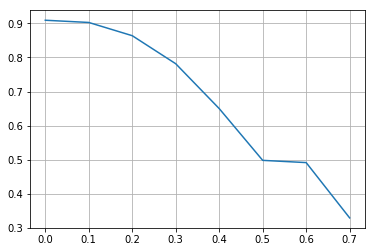

In [31]:
plot(acc_cox1['bins'],acc_cox1['betas']);
grid(True)

In [43]:
#targets.remove('A2a')

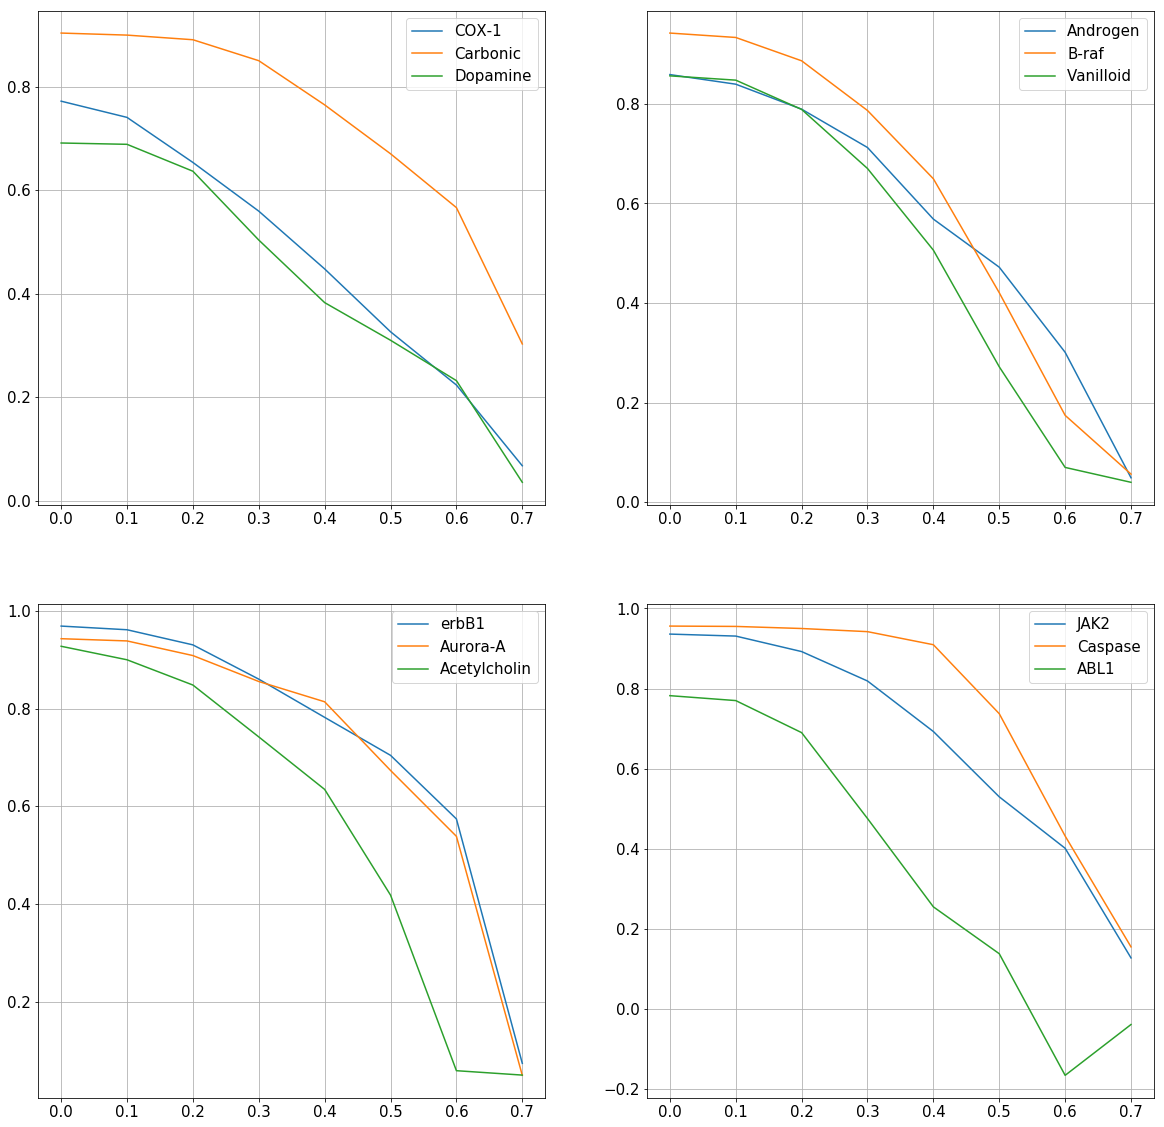

In [46]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)
for i in range(3):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
plt.subplot(222)
for i in range(3,6):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
plt.subplot(223)
for i in range(6,9):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
plt.subplot(224)
for i in range(9,12):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)

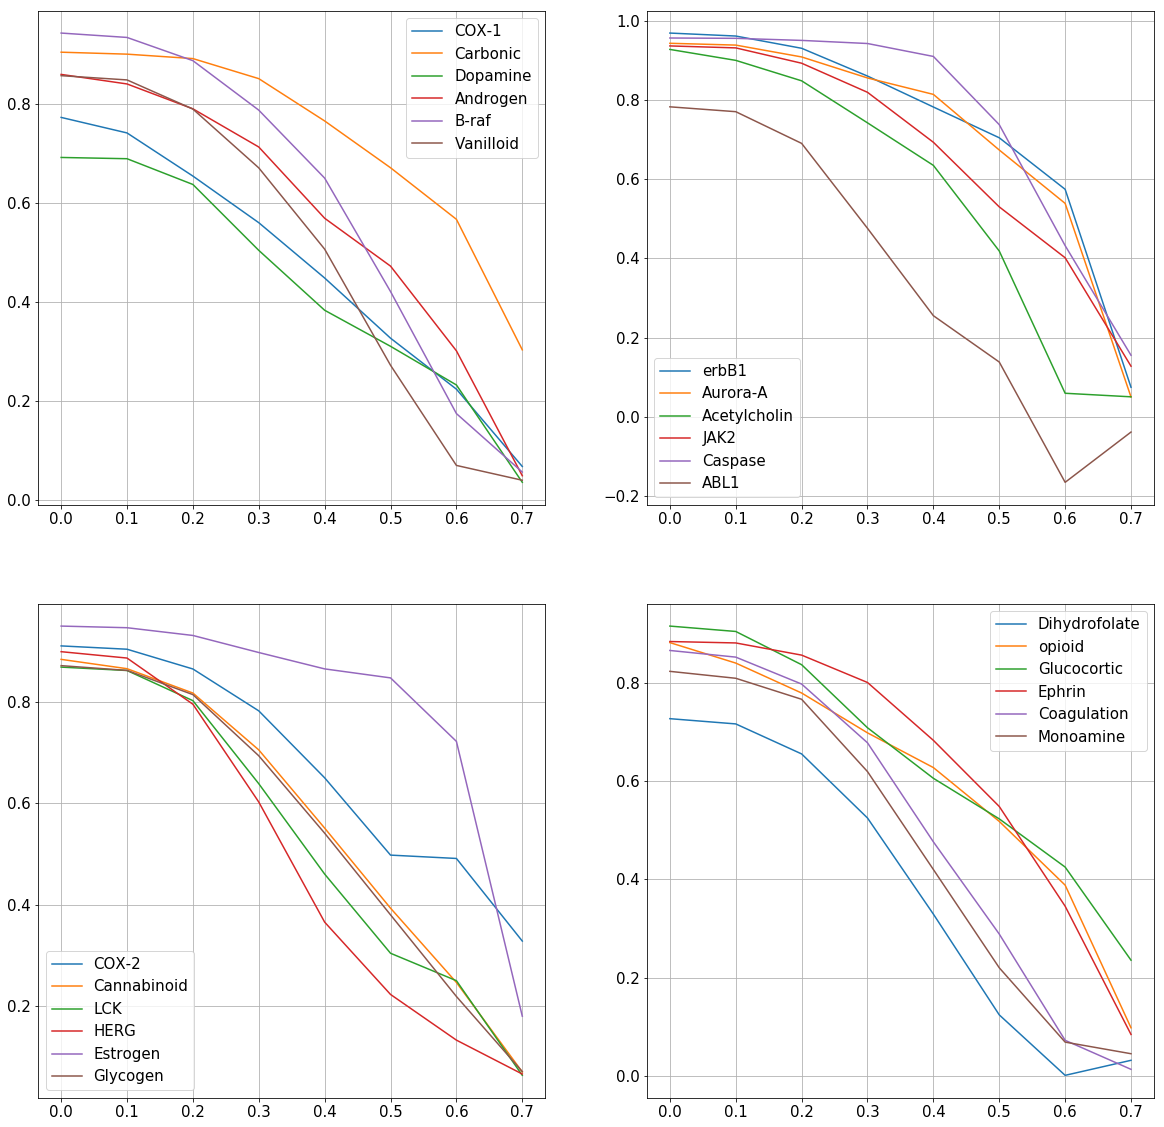

In [48]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
_ = plt.title('Ridge regression betas by Tanimoto distance')
plt.subplot(221)
for i in range(6):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
plt.subplot(222)
for i in range(6,12):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
plt.subplot(223)
for i in range(12,18):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
plt.subplot(224)
for i in range(18,24):
    preds, resps, _, _ = get_data(targets[i])
    acc = acc_plot(resps, preds, model_dict['ridge']['m'](**model_dict['ridge']['kw']))
    plot(acc['bins'],acc['betas'], label=targets[i]);
legend(loc='best')
grid(True)
savefig('ridge_perf_other_targets.eps')

In [49]:
pwd

u'/Users/oliverwatson/QuantileBootstrapDoubleRerun'